In [1]:
# Package Imports

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, KBinsDiscretizer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 100)

In [2]:
# Loading and understanding the data
raw_data = pd.read_csv("data.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1000 non-null   object 
 1   ela                939 non-null    float64
 2   financeAmount      939 non-null    float64
 3   address1           998 non-null    object 
 4   address2           862 non-null    object 
 5   address3           416 non-null    object 
 6   state              1000 non-null   object 
 7   city               1000 non-null   object 
 8   postcode           976 non-null    float64
 9   applicationStatus  1000 non-null   object 
 10  netSalary          1000 non-null   float64
 11  loanTenure         1000 non-null   int64  
 12  interestRate       1000 non-null   int64  
 13  loanApplied        1000 non-null   int64  
 14  jobTitle           1000 non-null   object 
 15  loanReason         1000 non-null   object 
dtypes: float64(4), int64(3), 

In [3]:
# Summary statistics of numerical features
raw_data.describe()

,ela,financeAmount,postcode,netSalary,loanTenure,interestRate,loanApplied
count,939.000000,939.000000,976.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,15959.531416,3532.694356,47655.150615,3457.413940,21.990000,17.997000,5581.600000
std,24027.757185,3351.043863,27143.513917,11434.249677,4.614021,0.094868,3255.973403
min,0.000000,0.000000,1000.000000,450.000000,6.000000,15.000000,1000.000000
25%,1000.000000,1000.000000,26092.500000,1990.442500,24.000000,18.000000,3000.000000
50%,11000.000000,2500.000000,43900.000000,2676.085000,24.000000,18.000000,5000.000000
75%,22000.000000,5000.000000,71800.000000,3700.000000,24.000000,18.000000,10000.000000
max,397000.000000,10000.000000,98000.000000,359313.000000,24.000000,18.000000,10000.000000


In [4]:
# Check if all ids are indeed unique
raw_data['id'].nunique()

1000

## NaN/Null Investigation and Handling

In [5]:
# Indentify columns with NaN
col_with_na = raw_data.columns[raw_data.isna().any()].tolist()
col_with_na

['ela', 'financeAmount', 'address1', 'address2', 'address3', 'postcode']

#### ela - Maximum loan amount which the applicant is eligible to loan based on his/her financial capability

In [6]:
ela_na = raw_data.query("ela.isna()")
ela_na.head()

,id,ela,financeAmount,address1,address2,address3,state,city,postcode,applicationStatus,netSalary,loanTenure,interestRate,loanApplied,jobTitle,loanReason
15,02c912c4-bb44-4028-88cb-f62814894137,NaN,NaN,802 BLOK C TINGKAT 8,KUARTERS FRU POLIS DEPOH,NaN,JOHOR,JOHOR BAHRU,80250.0,REJECTED,2100.00,24,18,5000,PARTS ASSISTANT,RENOVATION
17,02f0b3b1-52e4-4051-b71e-d0994fc9f337,NaN,NaN,77 JALAN 3/149D BANDAR BARU,SERI PETALING,NaN,KUALA LUMPUR,KUALA LUMPUR,57000.0,REJECTED,2000.00,24,18,10000,CASHIER,DEBTS CONSOLIDATION
25,03f3bceb-0d7d-4893-b01a-3bfa9c0de8dd,NaN,NaN,F-9-24,MENTARI COURT,"PETALING JAYA, SELANGOR",SELANGOR,PETALING JAYA,46150.0,REJECTED,3500.00,6,18,1100,BUILDING EXECUTIVE,DEBTS CONSOLIDATION
30,04dd3aff-5539-459d-8966-4bc55fc06a64,NaN,NaN,RL116 JALAN RESTU,RANTAU PERINTIS,BANDAR JENGKA,PAHANG,BANDAR PUSAT JENGKA,26400.0,REJECTED,6725.51,24,18,10000,PHARMACIST,EXPAND BUSINESS
52,08a39ec5-7e7d-48af-857d-84d696207de6,NaN,NaN,NO 109 JALAN P.I 3,TAMAN PEDAS INDAH,NaN,NEGERI SEMBILAN,REMBAU,71400.0,REJECTED,3000.00,24,18,10000,COURIER,RENOVATION


In [7]:
# Based on the below ela NaN analysis, the applicationStatus for all of them is REJECTED
ela_na['applicationStatus'].value_counts()

applicationStatus
REJECTED    61
Name: count, dtype: int64

In [8]:
# Check applicationStatus if ela is 0
# It appears that there is one case of when ela = 0 and loan is still approved, which should not be the case

if raw_data['ela'].min() == 0.0:
    print(raw_data[raw_data['ela'] == 0.0]['applicationStatus'].value_counts())

applicationStatus
REJECTED    228
APPROVED      1
Name: count, dtype: int64


In [9]:
raw_data.query("ela == 0.0 and applicationStatus == 'APPROVED'")

,id,ela,financeAmount,address1,address2,address3,state,city,postcode,applicationStatus,netSalary,loanTenure,interestRate,loanApplied,jobTitle,loanReason
292,2c40878b-aa10-4b65-b27a-9b55dbaba256,0.0,5000.0,NO 4250,KAMPUNG SELAMAT,NaN,PENANG,TASEK GELUGOR,NaN,APPROVED,1800.0,24,18,10000,MARKETING,OTHER USAGE


In [10]:
# ela NaN handling
# In all cases when ela is NaN, the application status is REJECTED. When ela is 0, for most cases the application status is REJECTED apart from 1 unique case where the application status is APPROVED. 
# It is likely that this unique case is an error in the data or a wrong decision was made as when ela is 0 they should not be eligible for a loan. 
# The way forward is to replace the NaN with 0 for ela and drop the unique case from the data.

data_p1 = raw_data[raw_data['id'] != '2c40878b-aa10-4b65-b27a-9b55dbaba256']
data_p1.loc[data_p1['ela'].isna(), 'ela'] = 0.0
data_p1['ela'].isna().sum()

0

#### financeAmount - Approved loan amount

In [11]:
financeAmount_na = data_p1[data_p1['financeAmount'].isna()]
display(financeAmount_na.head())
financeAmount_na['applicationStatus'].value_counts()

,id,ela,financeAmount,address1,address2,address3,state,city,postcode,applicationStatus,netSalary,loanTenure,interestRate,loanApplied,jobTitle,loanReason
15,02c912c4-bb44-4028-88cb-f62814894137,0.0,NaN,802 BLOK C TINGKAT 8,KUARTERS FRU POLIS DEPOH,NaN,JOHOR,JOHOR BAHRU,80250.0,REJECTED,2100.00,24,18,5000,PARTS ASSISTANT,RENOVATION
17,02f0b3b1-52e4-4051-b71e-d0994fc9f337,0.0,NaN,77 JALAN 3/149D BANDAR BARU,SERI PETALING,NaN,KUALA LUMPUR,KUALA LUMPUR,57000.0,REJECTED,2000.00,24,18,10000,CASHIER,DEBTS CONSOLIDATION
25,03f3bceb-0d7d-4893-b01a-3bfa9c0de8dd,0.0,NaN,F-9-24,MENTARI COURT,"PETALING JAYA, SELANGOR",SELANGOR,PETALING JAYA,46150.0,REJECTED,3500.00,6,18,1100,BUILDING EXECUTIVE,DEBTS CONSOLIDATION
30,04dd3aff-5539-459d-8966-4bc55fc06a64,0.0,NaN,RL116 JALAN RESTU,RANTAU PERINTIS,BANDAR JENGKA,PAHANG,BANDAR PUSAT JENGKA,26400.0,REJECTED,6725.51,24,18,10000,PHARMACIST,EXPAND BUSINESS
52,08a39ec5-7e7d-48af-857d-84d696207de6,0.0,NaN,NO 109 JALAN P.I 3,TAMAN PEDAS INDAH,NaN,NEGERI SEMBILAN,REMBAU,71400.0,REJECTED,3000.00,24,18,10000,COURIER,RENOVATION


applicationStatus
REJECTED    61
Name: count, dtype: int64

In [12]:
# Check applicationStatus if financeAmount is 0
# For all cases when financeAmount is 0, the application status is REJECTED

if raw_data['financeAmount'].min() == 0.0:
    print(raw_data[raw_data['financeAmount'] == 0.0]['applicationStatus'].value_counts())

applicationStatus
REJECTED    228
Name: count, dtype: int64


In [13]:
# Way forward is to replace the NaN with 0 for financeAmount
data_p1.loc[data_p1['financeAmount'].isna(), 'financeAmount'] = 0.0
data_p1['financeAmount'].isna().sum()

0

#### NaN/Null analysis for nominal data

address1  
address2  
address3  
postcode  

In [14]:
nan_nominal = ['address1', 'address2', 'address3', 'postcode']

for col in nan_nominal:
    print(f'Number of unique values for {col}:',data_p1[col].nunique())
    print(f'Number of NaN for {col}:', data_p1[col].isna().sum(), '\n')

Number of unique values for address1: 960
Number of NaN for address1: 2 

Number of unique values for address2: 805
Number of NaN for address2: 138 

Number of unique values for address3: 359
Number of NaN for address3: 583 

Number of unique values for postcode: 349
Number of NaN for postcode: 23 



In [15]:
# address1, address2, address3 will be dropped for the reasons below:
    # They are similar to identifier columns and will not add any value to the model
    # They have a lot of NaNs that can't be imputed
    # The model should not learn from these columns, as a person's address should not be a part of the model. If the address columns are included, the model will be biased to towards certain addresses of which occupants may change in the future, this includes states and cities.
    # It is ethically questionable to reject / approve loans based on the address of the applicant.

In [16]:
# The postcode also has similar issues to address but it is not as unique and is linked to a certain areas or regions. While including the postcode as a model input will cause similar issues as the address features but to lesser extent, exploring it will yield more insight.
postcode_stats = data_p1.groupby('postcode').agg(
    count = ('postcode', 'count'),
    approved_count=('applicationStatus', lambda x: (x == 'APPROVED').sum()),  
    rejected_count=('applicationStatus', lambda x: (x == 'REJECTED').sum()), 
    min_salary  = ('netSalary', 'min'),
    max_salary = ('netSalary', 'max'),
    mean_salary = ('netSalary', 'mean'),
    min_ela = ('ela', 'min'),
    max_ela = ('ela', 'max'),
    mean_ela = ('ela', 'mean'),
    min_loan=('loanApplied', 'min'),
    max_loan=('loanApplied', 'max'),
    mean_loan=('loanApplied', 'mean')
).sort_values(by='count', ascending=False)

postcode_stats.sample(20)

,count,approved_count,rejected_count,min_salary,max_salary,mean_salary,min_ela,max_ela,mean_ela,min_loan,max_loan,mean_loan
postcode,,,,,,,,,,,,
71300.0,3,1,2,2400.00,3700.00,2898.666667,19000.0,34000.0,26000.000000,2000,6400,3966.666667
20300.0,1,0,1,3695.00,3695.00,3695.000000,0.0,0.0,0.000000,5000,5000,5000.000000
77500.0,1,0,1,2136.42,2136.42,2136.420000,22000.0,22000.0,22000.000000,3500,3500,3500.000000
48300.0,1,0,1,3500.00,3500.00,3500.000000,43000.0,43000.0,43000.000000,3000,3000,3000.000000
75200.0,1,0,1,3000.00,3000.00,3000.000000,19000.0,19000.0,19000.000000,10000,10000,10000.000000
89747.0,1,0,1,3263.00,3263.00,3263.000000,0.0,0.0,0.000000,4000,4000,4000.000000
14100.0,3,0,3,2900.00,3700.00,3366.666667,10000.0,29000.0,19333.333333,1500,3000,2033.333333
31100.0,1,0,1,3800.00,3800.00,3800.000000,12000.0,12000.0,12000.000000,5000,5000,5000.000000
34300.0,1,1,0,5500.00,5500.00,5500.000000,43000.0,43000.0,43000.000000,3000,3000,3000.000000


In [17]:
postcode_counts = data_p1['postcode'].value_counts()
count_of_single_postcode = len(postcode_counts[postcode_counts == 1])
print("Count of a single unique postcode:", count_of_single_postcode)
print("Count of unique postcode:",len(postcode_counts))

Count of a single unique postcode: 151
Count of unique postcode: 349


In [18]:
# Additional analysis for applicationStatus by state
# It appears that state has minimal effect on applicationStatus. Moreover it is not a feature that should be included in the model due to potential discrimination.
agg_data = data_p1.groupby(['state', 'applicationStatus']).size().reset_index(name='count')

fig = px.bar(agg_data, x='state', y='count', color='applicationStatus', 
             width=1200, height=700, title='Application Status by State')
fig.show()

c:\Users\aahmadsazali\anaconda3\envs\nowcast\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [19]:
# Based on the findings above it appears that postcode has minimal impact on application Status. In addition, a significant number of poscodes are unique with one occurance. Therefore, it is recommended to not include the postcode as a model input.
# As a result all address and postcode columns will be dropped. Other id related columns such as state and city will also be dropped
data_p2 = data_p1.drop(columns=['address1', 'address2', 'address3', 'postcode','id','state','city'])
data_p2.sample(5)

,ela,financeAmount,applicationStatus,netSalary,loanTenure,interestRate,loanApplied,jobTitle,loanReason
438,0.0,0.0,REJECTED,2700.0,24,18,7500,DRIVER,DEBTS CONSOLIDATION
926,28000.0,7500.0,REJECTED,2650.0,24,18,7500,AUDIO VIDEO SYSTEM,OTHER USAGE
811,39000.0,5000.0,REJECTED,3300.0,24,18,5000,CREDIT ADMIN EXECUTIVE,DEBTS CONSOLIDATION
479,6000.0,3600.0,REJECTED,1670.0,24,18,3600,DRIVER LORI,DEBTS CONSOLIDATION
43,2000.0,1000.0,REJECTED,2800.0,24,18,1000,PRODUCTION PLANNER EXECUTIVE,RENOVATION


In [20]:
# Information for dataset after handling NaN and dropping columns
data_p2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ela                999 non-null    float64
 1   financeAmount      999 non-null    float64
 2   applicationStatus  999 non-null    object 
 3   netSalary          999 non-null    float64
 4   loanTenure         999 non-null    int64  
 5   interestRate       999 non-null    int64  
 6   loanApplied        999 non-null    int64  
 7   jobTitle           999 non-null    object 
 8   loanReason         999 non-null    object 
dtypes: float64(3), int64(3), object(3)
memory usage: 78.0+ KB


### Exploratory Data Analysis

In [21]:
# Target variable analysis, to determine if it is balanced
target_counts = data_p2['applicationStatus'].value_counts()
target_bar = px.bar(target_counts,  width=600, height=400, title='Application Status Counts')
target_bar.show()

# The target variable is imbalanced, however it should not be too great of an issue as the imbalance is not servere. Approximately 20% of the target is APPROVED. 
# This will be managed by performing stratified splitting during the model training to provide a more accurate estimation of model performance.

In [22]:
# Categorical feature analysis - jobTitle
job_title_counts = data_p2['jobTitle'].value_counts()

print("Number of unique job titles:", len(job_title_counts))
print("Number of single occurance job titles:", len(job_title_counts[job_title_counts == 1]))

Number of unique job titles: 590
Number of single occurance job titles: 475


In [23]:
# It appears that job title has a large number of single occurance samples. Therefore, it is recommended to not include the jobTitle as a model input.
frequent_jobs = job_title_counts[job_title_counts > 1]
fig = px.bar(frequent_jobs, width=1200, height=700, title='Frequency of Jobs with more than 1 occurance')
fig.show()

In [24]:
# Categorical feature analysis - loanReason 
loan_reason_counts = data_p2['loanReason'].value_counts()
print("Number of unique loan reasons:", len(loan_reason_counts))
print("Number of single occurance loan reasons:", len(loan_reason_counts[loan_reason_counts == 1]))

Number of unique loan reasons: 6
Number of single occurance loan reasons: 0


In [25]:
# loanReason will be processed through one hot encoding because of its categorical nature and small number of unique values
# It is likely that loanReason has a significant impact on applicationStatus.
# One hot encoding for loanReason will be applied using sklearn in the pipeline
agg_data = data_p2.groupby(['loanReason', 'applicationStatus']).size().reset_index(name='count')

fig = px.bar(agg_data, x='loanReason', y='count', color='applicationStatus', 
             width=1200, height=700, title='Application Status by Loan Reason')
fig.show()

c:\Users\aahmadsazali\anaconda3\envs\nowcast\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



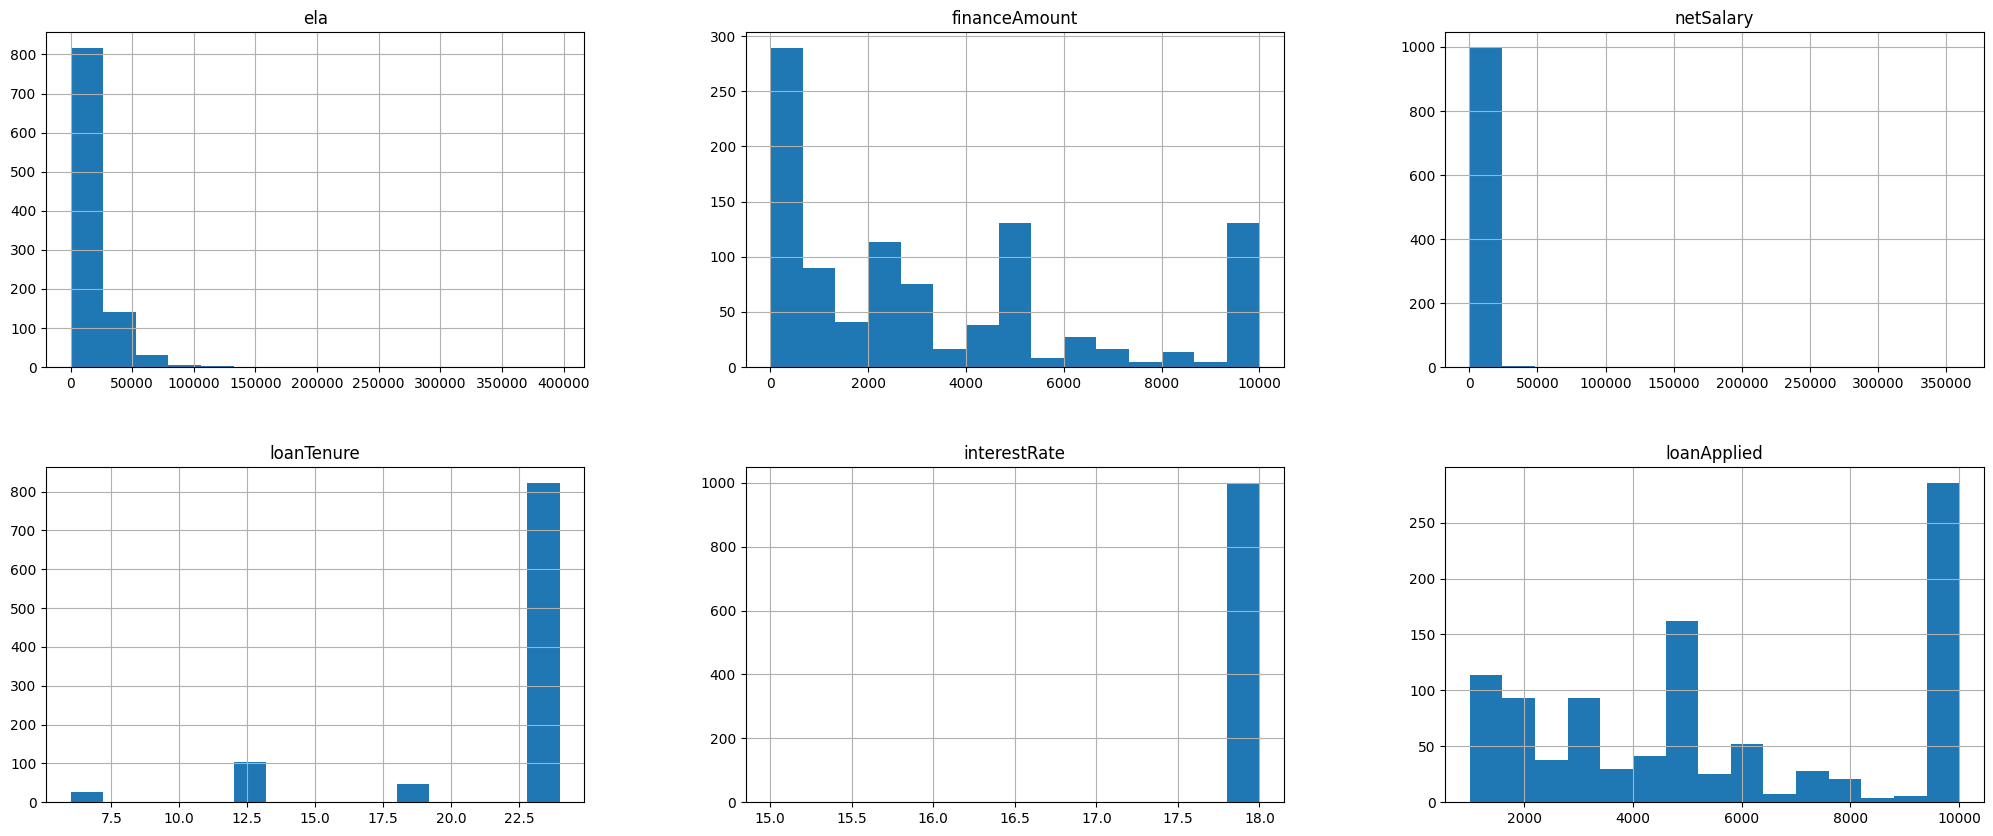

In [26]:
# Numerical feature distribution plots
numerical_features = data_p2.select_dtypes(include=['int64', 'float64'])

numerical_features.hist(figsize=(25, 10), bins=15, layout=(2, 3))
plt.show()


In [27]:
# Boxplots to understand numerical data distribution
for col in numerical_features.columns:
    fig = px.box(numerical_features, x=col, title=col, width=1500, height=400)
    fig.show()


In [28]:
# Suprisingly, interestRate only has 2 unique values, with a single occurance of 15%, while the rest is at 18%.
# As there is almost no variance in the interestRate, the feature for this dataset will likely have minimal impact on model performance and will be dropped, however in the future if the variable has more variance it should be revisited.
display(data_p2['interestRate'].value_counts())
display(data_p2.query("interestRate == 15"))
data_p2['interestRate'].var()

interestRate
18    998
15      1
Name: count, dtype: int64

,ela,financeAmount,applicationStatus,netSalary,loanTenure,interestRate,loanApplied,jobTitle,loanReason
410,10000.0,4100.0,REJECTED,1324.85,24,15,4100,GENERAL WORKER,DEBTS CONSOLIDATION


0.00900900900900901

#### Summary of findings for numerical variables and action to be taken

ela  
Has an extreme outliers, max value will be clipped to 75,000  

financeAmount  
No outliers and relatively normally distributed, no action to be taken  

netSalary  
Has an extreme outliers, max value will be clipped to 12,000  

loanTenure  
Appears to be of data type with 4 unique values, indicating it is of ordinal type 

interestRate  
Drop due to lack of variation  

loanApplied  
No outliers and relatively normally distributed, no action to be taken  

In [29]:
# Feature processing
clean_data = data_p2.drop(columns=['jobTitle', 'interestRate'])
clean_data.loc[:,'ela'] = clean_data['ela'].clip(upper=75000)
clean_data.loc[:,'netSalary'] = clean_data['netSalary'].clip(upper=12000)
clean_data.loc[:,'applicationStatus'] = clean_data['applicationStatus'].map({'APPROVED': '1', 'REJECTED': '0'}) # encoding of categorical target variable
clean_data.sample(10)

,ela,financeAmount,applicationStatus,netSalary,loanTenure,loanApplied,loanReason
782,1000.0,1000.0,0,920.00,6,1000,EDUCATION
563,13000.0,1000.0,0,1500.00,24,1000,EXPAND BUSINESS
333,1000.0,1000.0,0,1960.00,24,3000,RENOVATION
41,38000.0,3000.0,0,3907.00,18,3000,MEDICAL EXPENSES
366,2000.0,1000.0,0,3700.00,6,1000,DEBTS CONSOLIDATION
557,0.0,0.0,0,1300.00,12,1000,DEBTS CONSOLIDATION
316,9000.0,5000.0,1,2453.23,24,5000,DEBTS CONSOLIDATION
680,0.0,0.0,0,1500.00,24,5500,MEDICAL EXPENSES
96,6000.0,3000.0,0,707.00,24,3000,RENOVATION
950,3000.0,2000.0,1,5210.68,24,10000,DEBTS CONSOLIDATION


In [30]:
# Feature engineering, creation of additional features that might be useful for the model
clean_data['ratio_loan_finance'] = clean_data['loanApplied'] / clean_data['financeAmount']
clean_data['ratio_loan_eligibility'] = clean_data['loanApplied'] / clean_data['ela']
clean_data['ratio_loan_salary'] =  clean_data['loanApplied'] / clean_data['netSalary'] 
clean_data['ratio_salary_ela'] = clean_data['netSalary'] / clean_data['ela']
clean_data['monthly_payable'] = clean_data['financeAmount'] * 1.18 / clean_data['loanTenure']
clean_data['diff_salary_payable'] =  clean_data['netSalary'] - clean_data['monthly_payable']
clean_data['diff_loan_finance'] = clean_data['loanApplied'] - clean_data['financeAmount']
clean_data["interest_amount"] = clean_data["financeAmount"] * 0.18
clean_data["percent_salary_payable"] = clean_data["monthly_payable"] / clean_data["netSalary"]
clean_data.sample(10)


,ela,financeAmount,applicationStatus,netSalary,loanTenure,loanApplied,loanReason,ratio_loan_finance,ratio_loan_eligibility,ratio_loan_salary,ratio_salary_ela,monthly_payable,diff_salary_payable,diff_loan_finance,interest_amount,percent_salary_payable
758,23000.0,2000.0,1,2179.00,24,10000,OTHER USAGE,5.0,0.434783,4.589261,0.094739,98.333333,2080.666667,8000.0,360.0,0.045128
730,0.0,0.0,0,1652.29,24,10000,OTHER USAGE,inf,inf,6.052206,inf,0.000000,1652.290000,10000.0,0.0,0.000000
702,13000.0,3500.0,0,1574.85,24,3500,DEBTS CONSOLIDATION,1.0,0.269231,2.222434,0.121142,172.083333,1402.766667,0.0,630.0,0.109270
461,12000.0,5200.0,0,2515.00,24,5200,MEDICAL EXPENSES,1.0,0.433333,2.067594,0.209583,255.666667,2259.333333,0.0,936.0,0.101657
565,0.0,0.0,0,4160.00,24,5000,EXPAND BUSINESS,inf,inf,1.201923,inf,0.000000,4160.000000,5000.0,0.0,0.000000
849,49000.0,10000.0,1,7624.00,18,10000,RENOVATION,1.0,0.204082,1.311647,0.155592,655.555556,6968.444444,0.0,1800.0,0.085986
577,26000.0,2000.0,1,2500.00,24,2000,EXPAND BUSINESS,1.0,0.076923,0.800000,0.096154,98.333333,2401.666667,0.0,360.0,0.039333
377,45000.0,2000.0,0,4200.00,24,2000,DEBTS CONSOLIDATION,1.0,0.044444,0.476190,0.093333,98.333333,4101.666667,0.0,360.0,0.023413
552,4000.0,1000.0,0,2150.00,6,1000,DEBTS CONSOLIDATION,1.0,0.250000,0.465116,0.537500,196.666667,1953.333333,0.0,180.0,0.091473
777,0.0,0.0,0,3000.00,24,8000,MEDICAL EXPENSES,inf,inf,2.666667,inf,0.000000,3000.000000,8000.0,0.0,0.000000


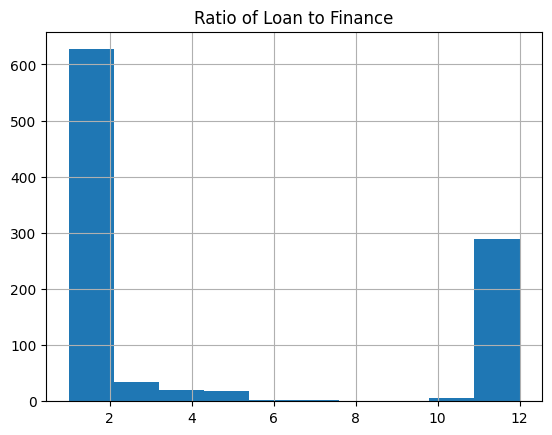

In [31]:
# Handling of inf values by replacing inf with the maximum value for that feature
col_with_inf = clean_data.columns[clean_data.isin([np.inf, -np.inf]).any()].tolist()

for col in col_with_inf:
    max_value = clean_data[col].replace([np.inf, -np.inf], np.nan).max() + 2
    clean_data[col] = clean_data[col].replace([np.inf, -np.inf], max_value)

clean_data['ratio_loan_finance'].hist()
plt.title('Ratio of Loan to Finance')
plt.show()

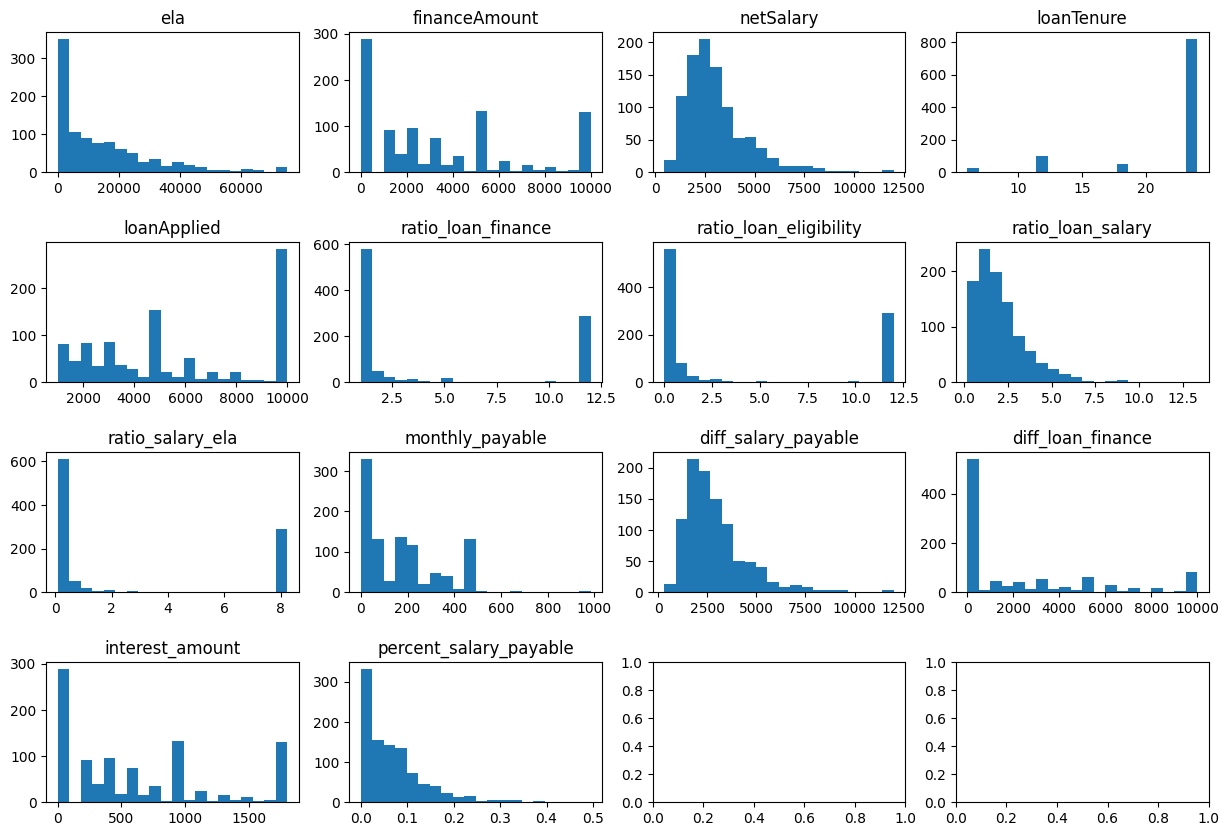

In [32]:

numerical_features2 = clean_data.select_dtypes(include=['int64', 'float64'])

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5) 

for i, feature in enumerate(numerical_features2.columns):
    ax = axs.flatten()[i]
    ax.hist(numerical_features2[feature], bins=20)
    ax.set_title(feature)

plt.show()

In [33]:
# Perform stratified train test split due to target imbalance
X = clean_data.drop(columns=['applicationStatus'])
y = clean_data['applicationStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024, stratify=y)

X_train.columns.tolist()

['ela',
 'financeAmount',
 'netSalary',
 'loanTenure',
 'loanApplied',
 'loanReason',
 'ratio_loan_finance',
 'ratio_loan_eligibility',
 'ratio_loan_salary',
 'ratio_salary_ela',
 'monthly_payable',
 'diff_salary_payable',
 'diff_loan_finance',
 'interest_amount',
 'percent_salary_payable']

In [34]:

def pipe_builder (model:tuple) -> Pipeline:
    scaled_cols = ['ela',
                'financeAmount',
                'netSalary',
                'loanApplied',
                'ratio_loan_finance',
                'ratio_loan_eligibility',
                'ratio_loan_salary',
                'ratio_salary_ela',
                'monthly_payable',
                'diff_salary_payable',
                'diff_loan_finance',
                'interest_amount',
                'percent_salary_payable',
                'loanTenure']

    column_trans = ColumnTransformer([
        ('numerical', StandardScaler(), scaled_cols),
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), ['loanReason'])
    ])
    pipe = Pipeline([('transformer', column_trans), model])
    
    return pipe

log_pipe = pipe_builder(('model', LogisticRegression(random_state=2024)))
rf_pipe = pipe_builder(('model', RandomForestClassifier(random_state=2024)))
svc_pipe = pipe_builder(('model', SVC(random_state=2024)))
knn = pipe_builder(('model', KNeighborsClassifier()))
gbc = pipe_builder(('model', GradientBoostingClassifier(random_state=2024)))
xgb = pipe_builder(('model', XGBClassifier(random_state=2024)))
rf_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['ela', 'financeAmount',
                                                   'netSalary', 'loanApplied',
                                                   'ratio_loan_finance',
                                                   'ratio_loan_eligibility',
                                                   'ratio_loan_salary',
                                                   'ratio_salary_ela',
                                                   'monthly_payable',
                                                   'diff_salary_payable',
                                                   'diff_loan_finance',
                                                   'interest_amount',
                                                   'percent_salary_payable',
                                                   'loanTenure']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['loanReason'])])),
                ('model', RandomForestClassifier(random_state=2024))])

In [35]:
# Test of other pipelines - EXPERIMENTAL

# def pipe_builder (model:tuple) -> Pipeline:

#     all_cols = ['ela',
#                 'financeAmount',
#                 'netSalary',
#                 'loanTenure',
#                 'loanApplied',
#                 'loanReason',
#                 'ratio_loan_finance',
#                 'ratio_loan_eligibility',
#                 'ratio_loan_salary',
#                 'ratio_salary_ela',
#                 'monthly_payable',
#                 'diff_salary_payable',
#                 'diff_loan_finance',
#                 'interest_amount',
#                 'percent_salary_payable']
    
#     power_cols = ['ela', 'ratio_loan_eligibility', 'ratio_loan_salary', 'diff_salary_payable', 'ratio_loan_salary',  ]
#     bined_cols = []
#     passthrough = ['interest_amount','monthly_payable', 'loanApplied', 'financeAmount','ratio_loan_finance', 'diff_loan_finance', 'netSalary','loanTenure']
#     # ordinal_col = ['loanTenure']

#     column_trans = ColumnTransformer([
#         ('power', PowerTransformer(method='yeo-johnson', standardize=False), power_cols),
#         # ('binned', KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile', random_state=2024, subsample=None), bined_cols),
#         # ('ordinal', OrdinalEncoder(), ordinal_col),
#         ('categorical', OneHotEncoder( handle_unknown='ignore'), ['loanReason'])
#     ], remainder='passthrough')
#     pipe = Pipeline([('transformer', column_trans), ('scaler', StandardScaler()), model])
    
#     return pipe

In [36]:
# Candidate Model Fit / Predict
rf_fit= rf_pipe.fit(X_train, y_train)
log_fit = log_pipe.fit(X_train, y_train)
svc_fit = svc_pipe.fit(X_train, y_train)
knn_fit= knn.fit(X_train, y_train)
gbc_fit = gbc.fit(X_train, y_train)
xgb_fit = xgb.fit(X_train, y_train.astype('int32'))

rf_pred = rf_pipe.predict(X_test)
log_pred = log_pipe.predict(X_test)
svc_pred = svc_pipe.predict(X_test)
knn_pred = knn.predict(X_test)
gbc_pred = gbc.predict(X_test)
xgb_pred = xgb.predict(X_test).astype('str')

In [37]:
# Candidate Model Evaluation
def model_metrics(model, y_test, y_pred):

    positive_label = '1'
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=positive_label)
    recall = recall_score(y_test, y_pred, pos_label=positive_label)
    f1 = f1_score(y_test, y_pred, pos_label=positive_label)
    roc_area = roc_auc_score(np.array(y_test, dtype='float64'), np.array(y_pred, dtype='float64'))

    result_df = pd.DataFrame({'Model': [model], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'ROC AUC': [roc_area]})
    return result_df

actual = y_test.values

rf_metrics = model_metrics('Random Forest Classifier', actual, rf_pred)
log_metrics = model_metrics('Logistic Regression', actual, log_pred)
svc_metrics = model_metrics('Support Vector Classifier', actual, svc_pred)
knn_metrics = model_metrics('KNN Classifier', actual, knn_pred)
gbc_metrics = model_metrics('Gradient Boosting Classifier', actual, gbc_pred)
xgb_metrics = model_metrics('XGB Classifier', actual, xgb_pred)

results = pd.concat([rf_metrics, log_metrics, svc_metrics, knn_metrics, gbc_metrics, xgb_metrics]).reset_index(drop=True)
results


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest Classifier,0.865,0.800000,0.476190,0.597015,0.722272
1,Logistic Regression,0.845,0.761905,0.380952,0.507937,0.674653
2,Support Vector Classifier,0.865,0.941176,0.380952,0.542373,0.687312
3,KNN Classifier,0.840,0.647059,0.523810,0.578947,0.723930
4,Gradient Boosting Classifier,0.865,0.741935,0.547619,0.630137,0.748493
5,XGB Classifier,0.865,0.777778,0.500000,0.608696,0.731013


In [38]:
# Best Candidate Model Tuning
"""
Based on the intial testing above, it seems that Gradient Boosting Classifier is the most promising model, it has the highest ROC AUC score and F1 score. Apart from that, it has acceptable inital precision score losing only to support vector classifier and has the 
highest recall.While support vector classifier has the highest precision, meaning most of its predicted 'APPROVED' values are correct, it has the lowest recall along with logistic regression. At a recall of 0.380952,this implies out of 100 approved applications, 
only 38 samples will be predicted as approved.

The gridsearch performed below will refit the model with the highest ROC AUC score. ROC AUC score is selected as it represents the area under the ROC curve which quantifies the overall perfromance of the model. A score of 0.5 is no better than random chance for 
a binary classifier. By refitting the search over the roc_auc score, the precision and recall scores will be improved, instead of focusing on either of them.
"""

gbc_params = {
    'model__loss': ['log_loss'],
    'model__learning_rate': [0.025, 0.05, 0.1],
    'model__n_estimators': [80, 100, 150, 175, 200, 250],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [1],
    'model__max_depth': [3, 4, 5],
    'model__random_state': [2024],
    'model__max_leaf_nodes' : [None]
}

gbc_pipe = pipe_builder(('model', GradientBoostingClassifier()))
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=2024)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
search = GridSearchCV(gbc_pipe, gbc_params, scoring=scoring, cv=cv, n_jobs=4, refit='f1',verbose = 3)
gbc_result = search.fit(X_train, y_train)
print(gbc_result.best_params_)

Fitting 7 folds for each of 54 candidates, totalling 378 fits


c:\Users\aahmadsazali\anaconda3\envs\nowcast\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]



{'model__learning_rate': 0.025, 'model__loss': 'log_loss', 'model__max_depth': 3, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 80, 'model__random_state': 2024}


In [39]:
pd.DataFrame(gbc_result.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__loss,param_model__max_depth,param_model__max_leaf_nodes,param_model__min_samples_leaf,param_model__min_samples_split,...,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,split5_test_roc_auc,split6_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.247921,0.006533,0.020227,0.003837,0.025,log_loss,3,None,1,2,...,0.821556,0.908102,0.962963,0.885185,0.921296,0.924537,0.921991,0.906519,0.040786,5
1,0.326178,0.012655,0.019229,0.004733,0.025,log_loss,3,None,1,2,...,0.823778,0.910417,0.962731,0.886343,0.919907,0.930093,0.915972,0.907034,0.040090,2
2,0.494354,0.008145,0.019702,0.004175,0.025,log_loss,3,None,1,2,...,0.828222,0.912037,0.957870,0.887731,0.908565,0.941667,0.916204,0.907471,0.038689,1
3,0.572156,0.018203,0.021717,0.005647,0.025,log_loss,3,None,1,2,...,0.826000,0.913426,0.956481,0.884954,0.911574,0.941204,0.912963,0.906657,0.039211,4
4,0.758218,0.045993,0.024437,0.008542,0.025,log_loss,3,None,1,2,...,0.827778,0.912500,0.955556,0.885880,0.911574,0.941667,0.912500,0.906779,0.038476,3


In [40]:
# GridSearch Results 
# {'model__learning_rate': 0.025, 'model__loss': 'log_loss', 'model__max_depth': 3, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 80, 'model__random_state': 2024}

params = {'model__learning_rate': 0.025, 'model__loss': 'log_loss', 'model__max_depth': 3, 'model__max_leaf_nodes': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 80, 'model__random_state': 2024}
# gbc_result.best_params_
gbc_pipe_final = pipe_builder(('model', GradientBoostingClassifier()))
gbc_pipe_final.set_params(**params)
gbc_pipe_final.fit(X_train, y_train)
pred = gbc_pipe_final.predict(X_test).astype('str')

evaluation = model_metrics('Gradient Boosting Classifier', actual, pred)
evaluation

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Gradient Boosting Classifier,0.88,0.909091,0.47619,0.625,0.731766


### Conclusion  

The highlights of the final model are as follows:  

- **Accuracy**: 0.88. This implies that out of 100 samples, 88 are correct regardless of label.
- **Precision**: 0.9. This implies that out of 100 predicted positive cases (APPROVED), 90 of them are correct.
- **Recall**: 0.47. Out of 100 actual APPROVED samples, the model will be able to recognize 47 of them and label the rest as REJECTED.

The high precision of the model is desired as it is ideal to minimize the cases of False Positives, considering the Precision-Recall trade-off. Ideally, it would be best to have the model predict positive cases accurately instead of being able to recognize more actual positive cases.

There is room for model performance improvement by adding additional features suggested below:

- Number of current loans held by the applicant
- Credit score
- Missed payment counts
- Total amount of loan
- Bankruptcy history
- Number of years paying debt
- Employment status